In [3]:
import numpy as np
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits
import matplotlib.pyplot as plt
import galah_li_rich_selection
import getpass
import mpl_scatter_density
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import h5py
import os
import pandas as pd
import astropy.stats
username = getpass.getuser()

%config InlineBackend.figure_format = 'retina'

## Figures for the Li-rich paper

In [4]:
# Opens the table and loads it into a FITS table
galah_idr3, galah_idr3_position = galah_li_rich_selection.load_table(
    f"/Users/{username}/ownCloud/unique_GALAH_iDR3_1912_with_RC_Clusters.fits")

## Creates the useful masks of the data

In [6]:
super_li = 2.7

(ignore_stars_idx, good_spec_idx,
 giant_idx, li_measured_idx, li_rich_idx) = galah_li_rich_selection.create_selections(galah_idr3, galah_idr3_position)

useful_stars_idx = ~ignore_stars_idx & good_spec_idx # All stars with "useful" values
useful_giants_idx = useful_stars_idx & giant_idx # All giants with "useful" values
useful_li_giants_idx = useful_giants_idx & li_measured_idx # All useful giants with lithium measurements
useful_li_rich_giants_idx = useful_li_giants_idx & li_rich_idx # All useful giants with li rich values
useful_super_li_rich_giants_idx = useful_li_giants_idx & (galah_idr3['a_li'] > super_li) # All useful giants with super li rich values
k2_fields = (galah_idr3['field_id'] > 6540) & (galah_idr3['field_id']< 6831)
tess_fields = (galah_idr3['field_id'] > 7080) & (galah_idr3['field_id']< 7364)

/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


In [7]:
# This just prints out some useful numbers for the paper

total_size = 567122 #This is the number of unique stars in the total dataset
print(f"This retained {100*np.sum(useful_stars_idx)/total_size:0.1f} per cent ({np.sum(useful_stars_idx)}/{total_size}) of the sample.")

print(f"{100*np.sum(useful_giants_idx)/np.sum(useful_stars_idx):0.1f} per cent ({np.sum(useful_giants_idx)}/{np.sum(useful_stars_idx)}) of our sample of ``good'' stars were identified as giant stars.")

print(f"Of these {np.sum(useful_giants_idx)} giant stars, only {np.sum(useful_li_giants_idx)} ({100*np.sum(useful_li_giants_idx)/np.sum(useful_giants_idx):0.1f} per cent) had a measured \\ali. ")

print(f"Our red giant data set contains {np.sum(useful_li_rich_giants_idx)}/{np.sum(useful_giants_idx)} ({np.sum(useful_li_rich_giants_idx)/np.sum(useful_giants_idx)*100:0.1f} per cent) stars with $\\ali> 1.5$")

print(f"Of those, {np.sum(useful_super_li_rich_giants_idx)} stars lie above the primordial value (WMAP reference?) of $\\ali> {super_li}$")

print(f"If we consider just the K2-HERMES fields: {np.sum(k2_fields & useful_giants_idx)}/{np.sum(k2_fields & useful_li_rich_giants_idx)}/{np.sum(k2_fields & useful_super_li_rich_giants_idx)}")
print(f"If we consider just the TESS-HERMES fields: {np.sum(tess_fields & useful_giants_idx)}/{np.sum(tess_fields & useful_li_rich_giants_idx)}/{np.sum(tess_fields & useful_super_li_rich_giants_idx)}")



This retained 75.2 per cent (426534/567122) of the sample.
33.1 per cent (141334/426534) of our sample of ``good'' stars were identified as giant stars.
Of these 141334 giant stars, only 13590 (9.6 per cent) had a measured \ali. 
Our red giant data set contains 1589/141334 (1.1 per cent) stars with $\ali> 1.5$
Of those, 395 stars lie above the primordial value (WMAP reference?) of $\ali> 2.7$
If we consider just the K2-HERMES fields: 21478/243/60
If we consider just the TESS-HERMES fields: 7868/86/20


### Creating the sample data table for the paper

In [9]:
star_list = [160519003601146,
             160517000101393,
             160522004101048,
             170531003801318,
             170517001801119,
             151110004201355]

for li_star_count, sobject_id in enumerate(star_list):
    star_of_interest_idx = (galah_idr3['sobject_id'] == sobject_id) & useful_giants_idx
    star = galah_idr3[star_of_interest_idx][0]
    row_str = ""
    row_str += f"{star['source_id']} & "
#     row_str += f"{star['star_id']} & "
    row_str += f"${star['ra']:0.3f}$ & "
    row_str += f"${star['dec']:0.3f}$ & "
    row_str += f"${star['rv_guess']:0.2f}\pm{star['e_rv_guess']:0.2f}$ & "
    row_str += f"${star['teff']:0.0f}\pm{star['e_teff']:0.0f}$ & "
    row_str += f"${star['logg']:0.2f}\pm{star['e_logg']:0.2f}$ & "
    row_str += f"${star['fe_h']:0.2f}\pm{star['e_fe_h']:0.2f}$ & "
    row_str += f"${star['a_li']:0.2f}\pm{star['e_a_li']:0.2f}$"
    row_str += "\\\\"
    print(row_str)

6137526858900209920 & $199.020$ & $-41.767$ & $-24.29\pm0.05$ & $3970\pm64$ & $1.63\pm0.15$ & $-0.17\pm0.06$ & $2.25\pm0.04$\\
5371899834025124608 & $175.501$ & $-48.171$ & $1.18\pm0.07$ & $4285\pm106$ & $1.75\pm0.16$ & $-0.22\pm0.14$ & $2.21\pm0.17$\\
6100901881763791232 & $223.933$ & $-42.034$ & $-18.09\pm0.10$ & $4429\pm67$ & $2.01\pm0.61$ & $-0.18\pm0.07$ & $2.40\pm0.06$\\
6235140814020759808 & $236.883$ & $-25.259$ & $-23.51\pm0.05$ & $4681\pm90$ & $2.31\pm0.16$ & $-0.18\pm0.10$ & $2.25\pm0.13$\\
6129493448995721984 & $180.111$ & $-50.437$ & $-49.77\pm0.11$ & $4980\pm66$ & $2.55\pm0.15$ & $-0.21\pm0.07$ & $2.25\pm0.06$\\
3155263089390175872 & $109.992$ & $9.198$ & $38.29\pm0.12$ & $5147\pm88$ & $2.72\pm0.16$ & $-0.18\pm0.10$ & $2.29\pm0.13$\\


### Plotting the Kiel diagram

426534
141334


/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


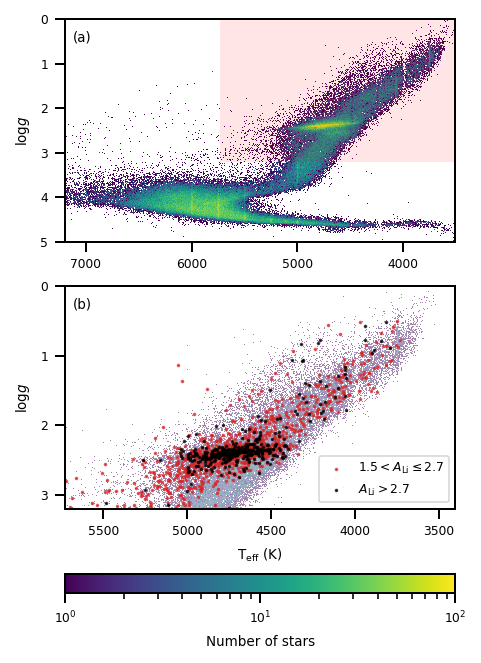

In [8]:
sns.set_context("paper", font_scale=0.7)
fig = plt.figure(figsize=(3.5, 6.0))
ax1 = fig.add_subplot(2, 1, 1, projection='scatter_density')
print(len(galah_idr3['teff'][useful_stars_idx]))
cmd = ax1.scatter_density(galah_idr3['teff'][useful_stars_idx],
                         galah_idr3['logg'][useful_stars_idx],
                         dpi=300, 
                         cmap=plt.cm.viridis, label='__nolabel__',
                         norm=LogNorm(vmin=1, vmax=100))
plt.sca(ax1)
plt.fill([3000,3000,5730,5730],
         [-1,3.2,3.2,-1],
         'r', alpha=0.1, edgecolor=None)
# cbar = fig.colorbar(cmd)
# cbar.set_label("Number of stars")

# ax.get_xaxis().set_ticklabels([])
ax1.set_ylim(5,0)
ax1.set_xticks(np.arange(4000,7500,1000))
ax1.set_xlim(7200, 3500)
ax1.set_ylabel(r"$\log g$")


ax2 = fig.add_subplot(2, 1, 2, projection='scatter_density')
print(len(galah_idr3['teff'][useful_giants_idx]))
ax2.scatter_density(galah_idr3['teff'][useful_giants_idx],
                         galah_idr3['logg'][useful_giants_idx],
                         dpi=300, 
                         cmap=plt.cm.viridis, alpha=0.5, label='__nolabel__',
                         norm=LogNorm(vmin=1, vmax=100))
plt.sca(ax2)
ax2.scatter(galah_idr3['teff'][useful_li_rich_giants_idx & ~useful_super_li_rich_giants_idx],
           galah_idr3['logg'][useful_li_rich_giants_idx & ~useful_super_li_rich_giants_idx],
           s=1, alpha=0.7, c='C3', label=r'$1.5 < A_\mathrm{Li} \leq 2.7$')
ax2.scatter(galah_idr3['teff'][useful_super_li_rich_giants_idx],
           galah_idr3['logg'][useful_super_li_rich_giants_idx],
           s=1, alpha=0.7, c='k', label='$A_\mathrm{Li} > 2.7$')
axes = np.array([ax1,ax2])
cbar = fig.colorbar(cmd, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.1)

cbar.set_label("Number of stars")
ax2.legend(loc='lower right')
[axes[ax_count].annotate(label, xy=(0.02,0.9), xycoords='axes fraction') for ax_count, label in enumerate(['(a)', '(b)'])]
ax2.set_yticks(np.arange(0,3.1,1))
ax2.set_ylim(3.2, 0)
ax2.set_xticks(np.arange(3500,5600,500))
ax2.set_xlim(5730,3400)
ax2.set_xlabel(r"$\mathrm{T}_\mathrm{eff}$ (K)")
ax2.set_ylabel(r"$\log g$")

fig.savefig('../paper/figures/teff_logg.pdf', bbox_inches='tight', dpi=500)
plt.show()

## Making the RC and RGB selections

In [12]:
# This makes my selections
teff_ref = -382.5 * galah_idr3['fe_h'] + 4607
z = 10**(galah_idr3['fe_h']+np.log10(0.0207))
j_k_0 = (-0.800 +
         0.046*galah_idr3['fe_h'] +
         0.008*galah_idr3['fe_h']**2 +
         -0.060*galah_idr3['fe_h']*(5040/galah_idr3['teff']) +
         1.199*(5040/galah_idr3['teff']) +
         0.132*(5040/galah_idr3['teff'])**2)
rc_1 = ((0.0004*(galah_idr3['teff']-teff_ref)+2.24 <= galah_idr3['logg']) &
        (galah_idr3['logg'] <= 0.0005 * (galah_idr3['teff']-teff_ref) + 2.48) & 
        (-180 < galah_idr3['teff']-teff_ref) &
        (galah_idr3['teff']-teff_ref < 400))
rc_2 = (z > 1.16*(j_k_0-0.083)**9 + 0.0011) & (z < 2.1*(j_k_0-0.39)**3 + 0.0034)# & (j_k_0 > 0.5)

#####These are the masks for my RC selection. Make sure to combine with useful_giants_idx, useful_li_giants_idx, useful_li_rich_giants_idx etc
RC_jeffrey_idx = rc_1 & rc_2
RGB_jeffrey_idx = ~RC_jeffrey_idx
rc_rgb_flag = np.ones(len(RC_jeffrey_idx))
rc_rgb_flag[RGB_jeffrey_idx] = 0

# This creates the sample of stars from Dennis's table
too_faint_idx = np.log10(galah_idr3['r_est']) < 0.193 * galah_idr3['w1mpro'] + 1.32 # Stars that are too faint to be RC
RC_Stello = (galah_idr3['RC_Stello'] == 1)# & ~too_faint_idx
RGB_Stello = galah_idr3['RC_Stello'] == 0

print(np.sum(useful_giants_idx & (RC_Stello & ~too_faint_idx)),
      np.sum(useful_giants_idx & RGB_Stello),
      np.sum(useful_giants_idx & ((RC_Stello & ~too_faint_idx) |RGB_Stello )  ))

424 1236 1660


/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


### Understanding the false positive rate

In [13]:
print(r"""\begin{table}
\begin{tabular}{llll}
\hline""")
RC_right = np.sum(useful_giants_idx & (RC_Stello & ~too_faint_idx) & RC_jeffrey_idx)
RC_wrong = np.sum(useful_giants_idx & (RC_Stello & ~too_faint_idx) & RGB_jeffrey_idx)
RGB_right = np.sum(useful_giants_idx & RGB_Stello & RC_jeffrey_idx)
RGB_wrong = np.sum(useful_giants_idx & RGB_Stello & RGB_jeffrey_idx)
print(f" & RC (This Work) & RGB (This Work) & Total\\\\")
print(r"\hline")
print(f"RC (Hon+2020) & {RC_right} ({RC_right/(RC_right + RGB_right)*100:0.0f}\%; {RC_right/(RC_right + RC_wrong)*100:0.0f}\%) & {RC_wrong} ({RC_wrong/(RC_wrong + RGB_wrong)*100:0.0f}\%; {RC_wrong/(RC_right + RC_wrong)*100:0.0f}\%) & {RC_right + RC_wrong}\\\\")
print(f"RGB (Hon+2020) & {RGB_right} ({RGB_right/(RC_right + RGB_right)*100:0.0f}\%; {RGB_right/(RGB_right + RGB_wrong)*100:0.0f}\%) & {RGB_wrong} ({RGB_wrong/(RC_wrong + RGB_wrong)*100:0.0f}\%; {RGB_wrong/(RGB_right + RGB_wrong)*100:0.0f}\%) & {RGB_right + RGB_wrong}\\\\")
print(r"\hline")
print(f"Total & {RC_right + RGB_right} & {RC_wrong + RGB_wrong} & {RC_right + RC_wrong + RGB_right + RGB_wrong}\\\\")
print(r"\hline")
print(r"""\label{tab:rc_comparison_spec}
\end{tabular}
\end{table}""")


total_Stello_Simpson = ((RC_Stello & ~too_faint_idx) | RGB_Stello) & (RC_jeffrey_idx | RGB_jeffrey_idx)
print(f"There are a total of {np.sum(total_Stello_Simpson)} stars with Stello and us seismic classifications.")

\begin{table}
\begin{tabular}{llll}
\hline
 & RC (This Work) & RGB (This Work) & Total\\
\hline
RC (Hon+2020) & 345 (64\%; 81\%) & 79 (7\%; 19\%) & 424\\
RGB (Hon+2020) & 191 (36\%; 15\%) & 1045 (93\%; 85\%) & 1236\\
\hline
Total & 536 & 1124 & 1660\\
\hline
\label{tab:rc_comparison_spec}
\end{tabular}
\end{table}
There are a total of 1686 stars with Stello and us seismic classifications.


In [17]:
for rc_selection in [[RC_jeffrey_idx, RGB_jeffrey_idx], [(RC_Stello & ~too_faint_idx), RGB_Stello]]:
    rc_idx, rgb_idx = rc_selection
    total_giant_stars = np.sum(useful_giants_idx & (rc_idx | rgb_idx))
    rc_all_stars = np.sum(useful_giants_idx & rc_idx)
    rgb_all_stars = np.sum(useful_giants_idx & rgb_idx)
    print(f"For our sample of {total_giant_stars} giants, {rc_all_stars} ({rc_all_stars/total_giant_stars*100:0.1f} per cent) are RC, and {rgb_all_stars} ({rgb_all_stars/total_giant_stars*100:0.1f} per cent) are RGB")

    total_giant_li_stars = np.sum(useful_li_rich_giants_idx & (rc_idx | rgb_idx))
    rc_li_stars = np.sum(useful_li_rich_giants_idx & rc_idx)
    rgb_li_stars = np.sum(useful_li_rich_giants_idx & rgb_idx)
    print(f"For our sample of {total_giant_li_stars} giants, {rc_li_stars} ({rc_li_stars/total_giant_li_stars*100:0.1f} per cent) are RC, and {rgb_li_stars} ({rgb_li_stars/total_giant_li_stars*100:0.1f} per cent) are RGB")

    print(f"RC ({rc_li_stars}/{rc_all_stars}; {rc_li_stars/rc_all_stars*100:0.1f} per cent)")
    print(f"RGB ({rgb_li_stars}/{rgb_all_stars}; {rgb_li_stars/rgb_all_stars*100:0.1f} per cent)")
    print("----")

# This is the useful list of dictionaries for the future plotting. The first is for my selection of RC/RGB stars, the second is Dennis's.
plot_lists = [[[RC_jeffrey_idx & ~((RC_Stello & ~too_faint_idx)),
                RGB_jeffrey_idx & ~(RGB_Stello)],
               dict(s=4, lw=0, alpha = 0.3, label="This work")],
              [[(RC_Stello & ~too_faint_idx),
                RGB_Stello],
               dict(s=50, marker='*', edgecolors='k', lw=0.5, alpha = 0.9, label="Seismic (Hon+20)")]
             ]
colors = ['C0', 'C2']

For our sample of 141334 giants, 44981 (31.8 per cent) are RC, and 96353 (68.2 per cent) are RGB
For our sample of 1589 giants, 852 (53.6 per cent) are RC, and 737 (46.4 per cent) are RGB
RC (852/44981; 1.9 per cent)
RGB (737/96353; 0.8 per cent)
----
For our sample of 1660 giants, 424 (25.5 per cent) are RC, and 1236 (74.5 per cent) are RGB
For our sample of 10 giants, 5 (50.0 per cent) are RC, and 5 (50.0 per cent) are RGB
RC (5/424; 1.2 per cent)
RGB (5/1236; 0.4 per cent)
----


### teff, logg, feh vs a_li plots
### vbroad vs a_li

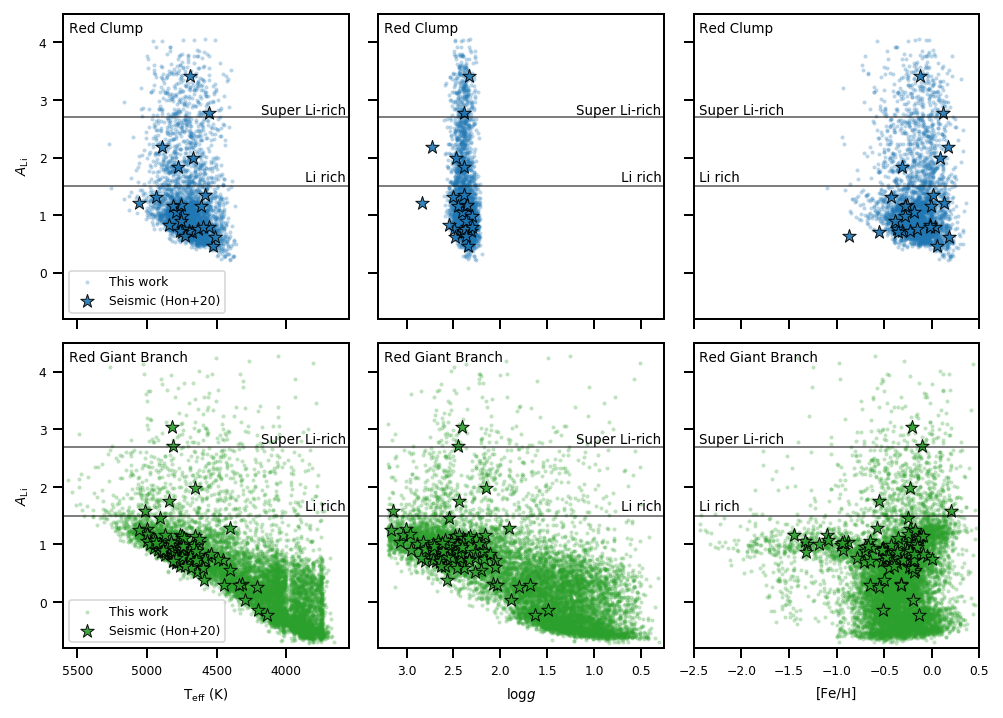

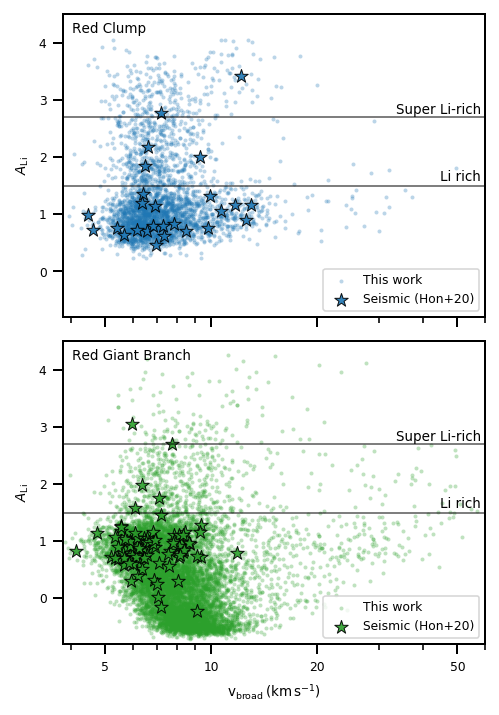

In [18]:


def rc_rgb_plot(plot_dicts):
#     xvalue, xlabel, xlims, log=False, loc='upper right', line_labels='right'
    sns.set_context("paper", font_scale=0.7)
    width = 3.5
    if len(plot_dicts) > 1:
        width = 7.
    fig, axes_all = plt.subplots(nrows = 2, ncols = len(plot_dicts), figsize=(width, 5.0),
                             sharey=True, sharex='col')
    file_name_str = ""
    for col_count, plot_dict in enumerate(plot_dicts):
        file_name_str += f"{plot_dict['xval']}_"
        if len(plot_dicts) > 1:
            axes = axes_all[:,col_count]
        else:
            axes = axes_all
        if ("xlog" in plot_dict) and (plot_dict["xlog"]):
            [ax.set_xscale('log') for ax in axes]
            axes[0].set_xticks([5, 10, 20, 50])
            axes[0].get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        if plot_dict["line_labels"] == 'left':
            x_loc = 0.02
        else:
            x_loc = 0.99
        [ax.annotate(label[0],
                     xy=(x_loc,label[1]),
                     xycoords='axes fraction',
                     horizontalalignment=plot_dict["line_labels"]) for label in [['Li rich', 0.45],
                                                                                 ['Super Li-rich', 0.67]] for ax in axes]
        axes[0].annotate('Red Clump', xy=(0.02,0.94), xycoords='axes fraction')
        axes[1].annotate('Red Giant Branch', xy=(0.02,0.94), xycoords='axes fraction')
        
        for plot_list in plot_lists:
            for idx_count, idx_select in enumerate(plot_list[0]):
                axes[idx_count].scatter(galah_idr3[plot_dict["xval"]][idx_select & useful_li_giants_idx],
                                        galah_idr3['a_li'][idx_select & useful_li_giants_idx],
                                        c = colors[idx_count],
                                        **plot_list[1])
        if col_count == 0:
            [ax.legend(loc=plot_dict["leg_loc"]) for ax in axes]
            [ax.set_ylabel(r"$A_\mathrm{Li}$") for ax in axes]
        axes[0].set_xlim(plot_dict["xlim"])
        axes[-1].set_xlabel(plot_dict["xlabel"])
    axes[0].set_ylim(-0.8, 4.5)    
    

    [ax.axhline(1.5, lw=1, alpha=0.5, c='k') for ax in axes_all.flatten()]
    [ax.axhline(2.7, lw=1, alpha=0.5, c='k') for ax in axes_all.flatten()]

    
    plt.tight_layout()

    fig.savefig(f'../paper/figures/{file_name_str}ali_rc_rgb.pdf', bbox_inches='tight', dpi=500)
    plt.show()
    
rc_rgb_plot([{"xval":"teff",
              "xlabel":r"$\mathrm{T}_\mathrm{eff}$ (K)",
              "xlim":[5600, 3550],
              "leg_loc":'lower left',
              "line_labels":'right'},
             {"xval":"logg",
              "xlabel":r"$\log g$",
              "xlim":[3.3, 0.25],
              "leg_loc":'upper left', 
              "line_labels":'right'},
             {"xval":"fe_h",
              "xlabel":"[Fe/H]",
              "xlim":[-2.5, 0.5],
              "leg_loc":'upper left',
              "line_labels":'left'}])

rc_rgb_plot([{"xval": "vbroad",
              "xlabel": r"$\mathrm{v}_\mathrm{broad}\,(\mathrm{km}\,\mathrm{s}^{-1})$",
              "xlim": [3.8,60], 
              "leg_loc": 'lower right',
              "line_labels":'right',
              "xlog": True}])
# You can make you're own plots with any values from the table. But you need to set up the dictionary with the useful values for the plotting to work.


### vbroad vs logg coloured by a_li

/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()


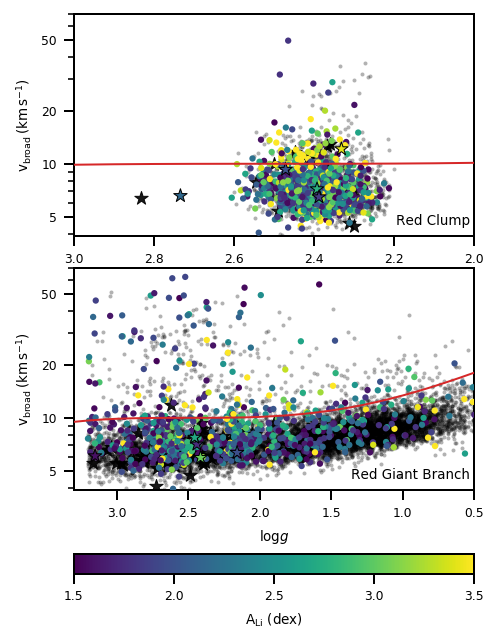

In [19]:
def rc_rgb_plot_2(xstuff, ystuff):
    xvalue, xlabel, xlims = xstuff
    yvalue, ylabel, ylims = ystuff

    colors = ['C0', 'C2']
    for plot_list in plot_lists:
        for idx_count, idx_select in enumerate(plot_list[0]):
            for li_idx in [galah_idr3['a_li'] <= 1.5,
                           galah_idr3['a_li'] > 1.5]:
                plot_idx = li_idx & idx_select & useful_li_giants_idx
                if np.sum(li_idx) == np.sum(galah_idr3['a_li'] <= 1.5):
                    kwargs = plot_list[1].copy()
                    kwargs['c'] = 'k'#colors[idx_count]
                else:
                    kwargs = plot_list[1].copy()
                    kwargs['c'] = galah_idr3['a_li'][plot_idx]
                    kwargs['s'] = np.max([kwargs['s'], 10])
                    kwargs['alpha'] = 1.0
                    kwargs['label']="__none__"
                    kwargs['zorder']= 1000
                    kwargs['vmin']= 1.5
                    kwargs['vmax']= 3.5
                    kwargs['zorder']= 1000
                li_points = axes[idx_count].scatter(galah_idr3[xvalue][plot_idx],
                                                    galah_idr3[yvalue][plot_idx],
                                                    **kwargs)
    axes[1].set_xlim(xlims)
    axes[0].set_ylim(ylims)
    axes[1].set_xlabel(xlabel)
    [ax.set_ylabel(ylabel) for ax in axes]
    
    
    [ax.plot(np.arange(0,4,0.1),
             (-1*(np.arange(0,4,0.1)-2.5)**3)+10, c='C3', lw=1, zorder=10000) for ax in axes]
    [ax.set_yscale('log') for ax in axes]
    [axes[ax_count].annotate(label,
                             xy=(0.99,0.05),
                             xycoords='axes fraction', horizontalalignment='right') for ax_count, label in enumerate(['Red Clump', 'Red Giant Branch'])]
    axes[1].set_yticks([5, 10, 20, 50])
    axes[1].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.tight_layout()
    cbar = fig.colorbar(li_points, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.1)
    cbar.set_label("$\mathrm{A}_\mathrm{Li}$ (dex)")
    cbar.set_ticks(np.arange(1.5, 3.6, 0.5))


sns.set_context("paper", font_scale=0.7)
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(3.5, 5.0),
                         sharey=True, sharex=False)
rc_rgb_plot_2(["logg", r"$\log g$", [3.3, 0.5]],
              ['vbroad', r"$\mathrm{v}_\mathrm{broad}\,(\mathrm{km}\,\mathrm{s}^{-1})$", [3.9, 70]])
axes[0].set_xlim([3, 2])
fig.savefig(f'../paper/figures/logg_vbroad_rc_rgb.pdf', bbox_inches='tight', dpi=500)
plt.show()

### Infrared excess

/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


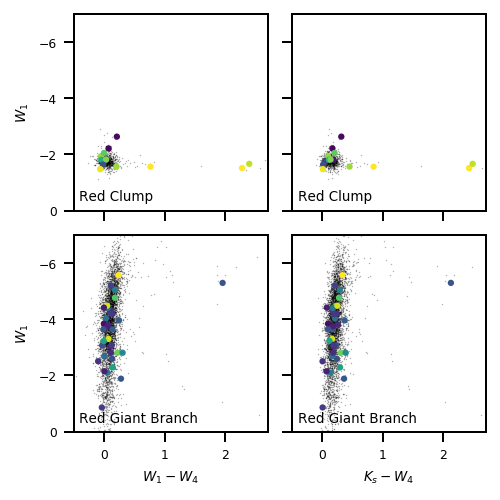

In [20]:
def get_values(value, dist=False):
    if len(value) == 1:
        if not dist:
            return galah_idr3[value[0]]
        else:
            return galah_idr3[value[0]]-(5*np.log10(galah_idr3['r_est'])-5)
    else:
        
        return galah_idr3[value[0]] - galah_idr3[value[1]]
    

def rc_rgb_plot_2(xstuff, ystuff, axes, dist=False):
    xvalue, xlabel, xlims = xstuff
    yvalue, ylabel, ylims = ystuff
    xvalue = get_values(xvalue)
    yvalue = get_values(yvalue, dist=dist)
    for plot_list in plot_lists:
        for idx_count, idx_select in enumerate(plot_list[0]):
            for li_idx in [galah_idr3['a_li'] > 1.5,
                           ~(galah_idr3['a_li'] > 1.5)]:
                plot_idx = (li_idx & idx_select & useful_giants_idx &
                            (galah_idr3['cc_flags'] == '0000') &
                            (galah_idr3['ph_qual'] == 'AAAA'))
                if np.sum(li_idx) == np.sum(~(galah_idr3['a_li'] > 1.5)):
                    kwargs = plot_list[1].copy()
                    kwargs['c'] = 'k'#colors[idx_count]
                    kwargs['s'] = 0.5
                else:
                    kwargs = plot_list[1].copy()
                    kwargs['c'] = galah_idr3['a_li'][plot_idx]
                    kwargs['s'] = np.max([kwargs['s'], 10])
                    kwargs['alpha'] = 1.0
                    kwargs['label']="__none__"
                    kwargs['zorder']= 1000
                    kwargs['vmin']= 1.5
                    kwargs['vmax']= 3.5
                axes[idx_count].scatter(xvalue[plot_idx],
                                        yvalue[plot_idx],
                                        **kwargs)
        break
    axes[0].set_xlim(xlims)
    axes[0].set_ylim(ylims)
    axes[1].set_xlabel(xlabel)
#     [ax.set_ylabel(ylabel) for ax in axes]
    
#     [ax.set_yscale('log') for ax in axes]
#     [ax.legend() for ax in axes]
    [axes[ax_count].annotate(label,
                             xy=(0.03,0.05),
                             xycoords='axes fraction') for ax_count, label in enumerate(['Red Clump', 'Red Giant Branch'])]


sns.set_context("paper", font_scale=0.7)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(3.5, 3.5),
                         sharey=True, sharex=True)
rc_rgb_plot_2([["w1mpro","w4mpro"], r"$W_1-W_4$", [-0.4, 3]],
              [["w1mpro",], r"$W_1$", [0, -7]], axes[:,0], dist=True)
rc_rgb_plot_2([["ks_m","w4mpro"], r"$K_s-W_4$", [-0.4, 3]],
              [["w1mpro",], r"$W_1$", [0, -7]], axes[:,1], dist=True)
[ax.set_ylabel(r"$W_1$") for ax in axes[:,0]]
# [ax.set_xscale('log') for ax in axes[:,0]]
axes[0,0].set_xlim([-0.5,2.7])
axes[0,0].set_xticks(np.arange(0,3,1))
axes[0,0].set_yticks(np.arange(-6,1,2))
plt.tight_layout()
fig.savefig(f'../paper/figures/infrared_excess_rc_rgb.pdf', bbox_inches='tight', dpi=500)
plt.show()

### Metallicity occurrence rates

In [ ]:
# from sklearn.neighbors import KernelDensity
def hist_laxis(data, bins):
    # Setup bins and determine the bin location for each element for the bins
#     R = range_limits
    N = data.shape[-1]
#     bins = np.linspace(R[0],R[1],n_bins+1)
    data2D = data.reshape(-1,N)
    idx = np.searchsorted(bins, data2D,'right')-1

    # Some elements would be off limits, so get a mask for those
    bad_mask = (idx==-1) | (idx==len(bins))

    # We need to use bincount to get bin based counts. To have unique IDs for
    # each row and not get confused by the ones from other rows, we need to 
    # offset each row by a scale (using row length for this).
    scaled_idx = len(bins)*np.arange(data2D.shape[0])[:,None] + idx

    # Set the bad ones to be last possible index+1 : n_bins*data2D.shape[0]
    limit = len(bins)*data2D.shape[0]
    scaled_idx[bad_mask] = limit

    # Get the counts and reshape to multi-dim
    counts = np.bincount(scaled_idx.ravel(),minlength=limit+1)[:-1]
    counts.shape = data.shape[:-1] + (len(bins),)
    return counts


sns.set_context("paper", font_scale=0.7)
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(3.5, 4.8),
                         sharey='row', sharex=True)

bin_width = 0.1
bins = np.arange(-2.5, 0.8, bin_width)
colours = ['C0', 'C2', 'k']

def both_type_bars(x, y, ax, yerr=None):
    ax.step(x, y, colours[col_num], lw=0.8)
    ax.bar(x-bin_width/2, y,
           yerr=yerr,
           width = bin_width, error_kw=dict(ecolor=kwargs['color']), **kwargs)
    
def calc_yerr(bootstrap_array, multiplier):
    bootstrap_array = bootstrap_array * multiplier
    median = np.median(bootstrap_array, axis=0)
    bottom_err =( median - np.percentile(bootstrap_array, 10, axis=0))
    top_err = (np.percentile(bootstrap_array, 90, axis=0) - median)
    return median, [bottom_err, top_err]
    
multiplier = [1/(10**2), 1/(10**3), 100]
for col_num, sample_idx in enumerate([RC_jeffrey_idx,
                                      RGB_jeffrey_idx,
                                      RC_jeffrey_idx | RGB_jeffrey_idx
                                     ]):
    ax = axes[:,col_num]
    kwargs = dict(alpha=0.5, lw=1.0, color=colours[col_num])
    li_feh_counts = hist_laxis(astropy.stats.bootstrap(galah_idr3[sample_idx & useful_li_rich_giants_idx]['fe_h'], bootnum=100), bins=bins)
    full_feh_counts = hist_laxis(astropy.stats.bootstrap(galah_idr3[sample_idx & useful_giants_idx]['fe_h'], bootnum=100), bins=bins)
    occurrence_rate_counts = li_feh_counts / full_feh_counts
    
    for row_count, counts in enumerate([li_feh_counts, full_feh_counts, occurrence_rate_counts]):
        print(row_count)
        medians, yerrs = calc_yerr(counts, multiplier[row_count])
        both_type_bars(bins, medians, ax[row_count], yerr=yerrs)

        
axes[1,0].set_yticks(np.arange(0,20,4))
axes[1,0].set_ylim([0, 13.0])

axes[0,0].set_yticks(np.arange(0,2.1,1))
axes[0,0].set_xticks(np.arange(-2.0,+0.6, 1.0))
axes[0,0].set_xlim([-2.5, 0.4])

axes[2,0].set_yticks(np.arange(0,5.1,1))
axes[2,0].set_ylim(0, 5.5)

axes[0,0].set_ylabel('Number of stars ($/100$)')
axes[1,0].set_ylabel(r'Number of stars ($/1000$)')
axes[2,0].set_ylabel('Occurence rate (%)')

[axes[0,ax_count].set_title(label) for ax_count, label in enumerate(['Red clump', 'Red giant branch'])]#, 'Entire sample'])]
[ax.set_xlabel('[Fe/H]') for ax in axes[-1,:]]

[ax.set_xlabel('[Fe/H]') for ax in axes[-1,:]]

for row_count, start_str in enumerate(['RC', 'RGB']):
    for col_count, full_str in enumerate([f'Li-rich {start_str}', f'All {start_str}']):
        axes[col_count,row_count].annotate(full_str, xy=(0.04,0.90), xycoords='axes fraction')
plt.tight_layout()
fig.align_labels()
fig.savefig(f'../paper/figures/feh_li_occurence.pdf', bbox_inches='tight', dpi=500)
plt.show()

### Lithium rich stars in clusters

In [ ]:
sns.set_context("paper", font_scale=0.7)

fig = plt.figure(figsize=(3.5, 3.5))
axes_gc = fig.add_subplot(2, 2, 1, projection='scatter_density')
axes_oc = fig.add_subplot(2, 2, 3, projection='scatter_density')
axes_gc_kiel = fig.add_subplot(2, 2, 2, projection='scatter_density')
axes_oc_kiel = fig.add_subplot(2, 2, 4, projection='scatter_density')

label_list = ["(a)\nGC stars", "(b)\nGC stars", "(c)\nOC stars",  "(d)\nOC stars"]
for ax_count, ax in enumerate([axes_gc, axes_gc_kiel, axes_oc, axes_oc_kiel]):
    ax.annotate(label_list[ax_count], (0.03, 0.83), xycoords='axes fraction')
for ax_count, ax in enumerate([axes_gc, axes_oc]):
    cmd = ax.scatter_density(galah_idr3['A_Li'][useful_stars_idx & li_measured_idx],
                             galah_idr3['logg'][useful_stars_idx & li_measured_idx],
                             dpi=200, alpha=0.4,
                             cmap=plt.cm.viridis, label='__nolabel__',
                             norm=LogNorm(vmin=1, vmax=50)
                            )
    
for ax_count, ax in enumerate([axes_gc_kiel, axes_oc_kiel]):
    cmd = ax.scatter_density(galah_idr3['teff'][useful_stars_idx],
                             galah_idr3['logg'][useful_stars_idx],
                             dpi=200, alpha=0.4,
                             cmap=plt.cm.viridis, label='__nolabel__',
                             norm=LogNorm(vmin=1, vmax=100)
                            )

kwargs = [dict(fmt='o', markersize=1, mew=0.0, elinewidth=0.1, c='k', label='All Cluster stars'),
          dict(fmt='o', markersize=1, mew=0.5, elinewidth=0.5, c='C0', label='All Cluster giant stars'),
          dict(fmt='*', markersize=10, mew=0.5, elinewidth=0.5, c='k', label='All Cluster Li giant stars'),
          dict(fmt='s', markersize=3, mew=0.3, elinewidth=0.5, c='C3', zorder=1000, label='Li-rich stars'),
         ]

globular_cluster_idx = [len(string)>0 for string in galah_idr3['GlobularCluster']]
open_cluster_idx = [len(string)>0 for string in galah_idr3['OpenCluster']]
for idx_count, idx in enumerate([useful_stars_idx & ~useful_giants_idx,
                                 useful_giants_idx & ~useful_li_rich_giants_idx,
                                 useful_li_rich_giants_idx,
                                 ~useful_li_rich_giants_idx & (galah_idr3['logg'] < 3.5) & (galah_idr3['teff'] < 6000) & li_rich_idx
                                ]):
    for ax_cluster_stuff in [[globular_cluster_idx, axes_gc, axes_gc_kiel],
                             [open_cluster_idx, axes_oc, axes_oc_kiel],]:
        cluster_idx, ax_li, ax_kiel = ax_cluster_stuff
        ax_li.errorbar((galah_idr3['A_Li'])[idx & cluster_idx],
                         (galah_idr3['logg'])[idx & cluster_idx],
#                          xerr=(galah_idr3['e_A_Li'])[idx & cluster_idx],
                         **kwargs[idx_count])
        ax_kiel.errorbar((galah_idr3['teff'])[idx & cluster_idx],
                              (galah_idr3['logg'])[idx & cluster_idx],
                              **kwargs[idx_count])
        
def sharex(ax_1, ax_2, limits, label):
    ax_1.get_shared_x_axes().join(ax_1, ax_2)
    ax_1.set_xlim(limits)
    ax_1.set_xticklabels([])
    ax_2.set_xlabel(label)
    
def sharey(ax_1, ax_2, limits, label):
    ax_1.get_shared_y_axes().join(ax_1, ax_2)
    ax_1.set_ylim(limits)
    ax_2.set_yticklabels([])
    ax_1.set_ylabel(label)

[ax.axvline(1.5, lw=0.45, c='k') for ax in [axes_oc, axes_gc]]
[ax.axvline(2.7, lw=0.45, c='k') for ax in [axes_oc, axes_gc]]

sharex(axes_gc, axes_oc, [4.5, -0.8], r'$A_\mathrm{Li}$')
sharex(axes_gc_kiel, axes_oc_kiel, [7200, 3500], r'$T_\mathrm{eff}$')
sharey(axes_gc, axes_gc_kiel, [5, 0.5], r'$\log g$')
sharey(axes_oc, axes_oc_kiel, [5, 0.5], r'$\log g$')


fig.tight_layout()
plt.savefig("../paper/figures/galah_gc_li.pdf", bbox_inches='tight', dpi=500)
plt.show()

In [ ]:
gc_star_count = np.sum(globular_cluster_idx & useful_stars_idx)
giant_gc_star_count = np.sum(globular_cluster_idx & useful_giants_idx)
measured_gc_li_star_count = np.sum(globular_cluster_idx & li_measured_idx)
cluster_names = np.unique(galah_idr3[globular_cluster_idx]['GlobularCluster'])

print(f"We identified {gc_star_count} globular cluster stars across {len(cluster_names)} clusters.")
print(f"{measured_gc_li_star_count} globular cluster stars have a measured lithium ({measured_gc_li_star_count}/{giant_gc_star_count}; {measured_gc_li_star_count/giant_gc_star_count*100:0.0f} per cent)")

In [ ]:
for cluster in cluster_names:
    print(cluster, np.sum(galah_idr3['GlobularCluster']==cluster))

In [ ]:
oc_star_count = np.sum(open_cluster_idx & useful_stars_idx)
giant_oc_star_count = np.sum(open_cluster_idx & useful_giants_idx)
measured_oc_li_star_count = np.sum(open_cluster_idx & useful_li_giants_idx)
cluster_names = np.unique(galah_idr3[open_cluster_idx]['OpenCluster'])

print(f"We identified {oc_star_count} globular cluster stars across {len(cluster_names)} clusters.")
print(f"{measured_oc_li_star_count} globular cluster stars have a measured lithium ({measured_oc_li_star_count}/{giant_oc_star_count}; {measured_oc_li_star_count/giant_oc_star_count*100:0.0f} per cent)")

In [ ]:
for cluster in cluster_names:
    print(cluster, np.sum(galah_idr3['OpenCluster']==cluster))

## Make the Appendix figures for the RC/RGB selection

/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._densi

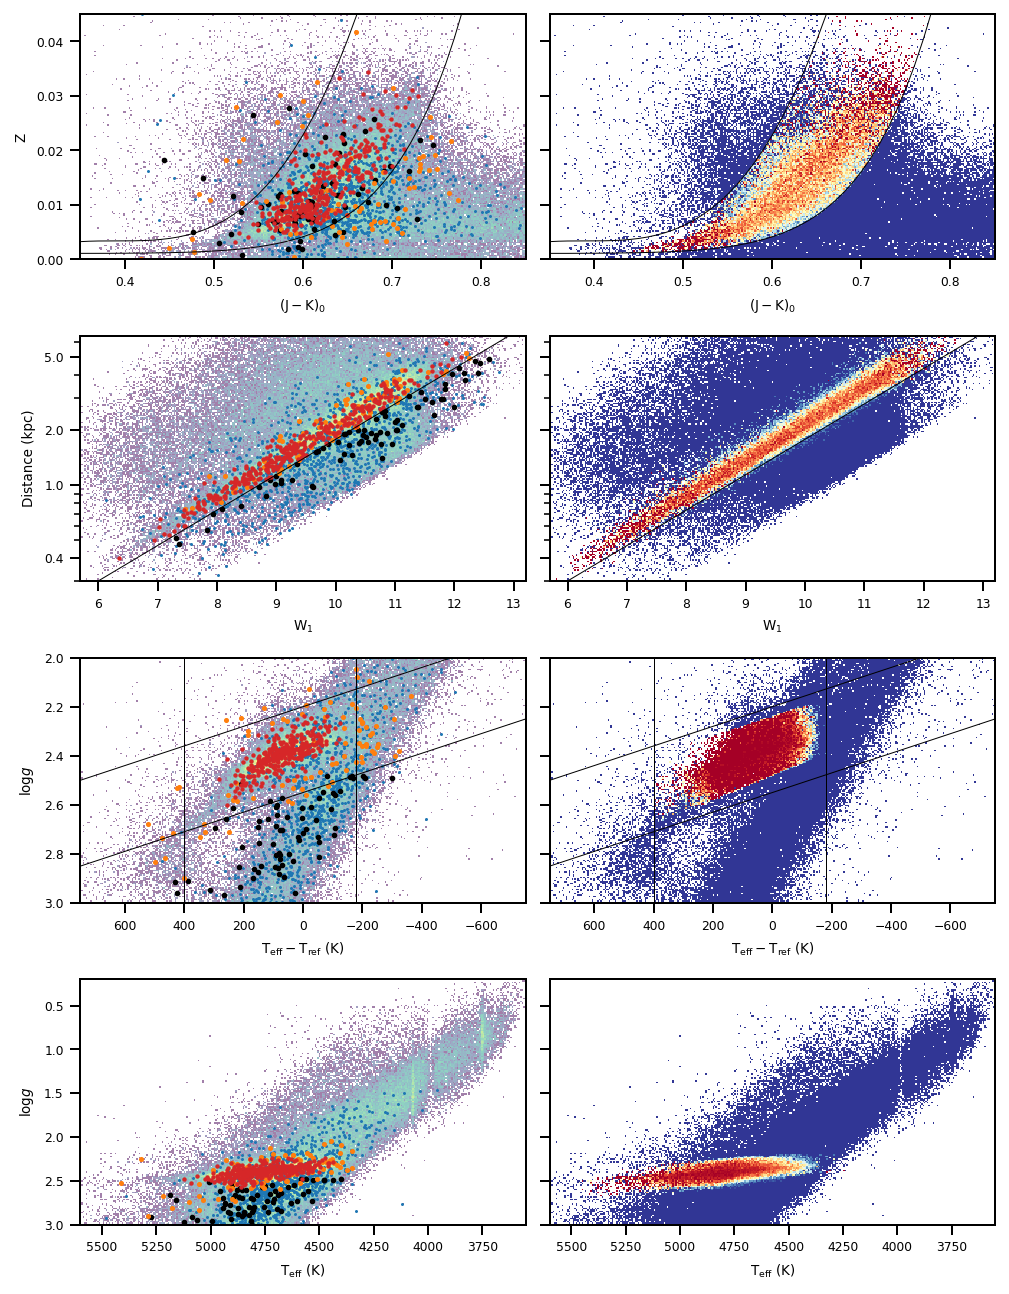

In [21]:


sns.set_context("paper", font_scale=0.7)
fig = plt.figure(figsize=(3.5*2, 9.0))

ax_list = [{"x": j_k_0,
            "y": z,
            "xlim":[0.35,0.85], "xlabel": r"$(\mathrm{J}-\mathrm{K})_0$",
            "ylim":[0,0.045], "ylabel": "Z", "y_ticks": np.arange(0,0.05, 0.01),
            "x_line":np.arange(0, 2, 0.01),
            "y_lines":[1.16*(np.arange(0, 2, 0.01)-0.083)**9 + 0.0011,
                       2.1*(np.arange(0, 2, 0.01)-0.39)**3 + 0.0034],
#             "v_lines":[0.5]
           },
           {"x": galah_idr3['w1mpro'],
            "y": galah_idr3['r_est']/1000,
            "xlim":[5.7, 13.2], "xlabel": r"$\mathrm{W}_1$",
            "ylim":[.300,6.500], "ylabel": "Distance (kpc)",
            "x_line": np.arange(4, 14, 0.01),
            "y_lines": [10**(0.193 * np.arange(4, 14, 0.01) + 1.32)/1000,],
            "ylog": True
           },
           {"x": galah_idr3['teff']-teff_ref,
            "y": galah_idr3['logg'],
            "xlim":[750, -750], "xlabel": r"$\mathrm{T}_\mathrm{eff}-\mathrm{T}_\mathrm{ref}$ (K)",
            "ylim":[3,2], "ylabel": r"$\log g$",
            "x_line":np.arange(-1000, 1000, 10),
            "y_lines":[0.0004*np.arange(-1000, 1000, 10)+2.2,
                       0.0004*np.arange(-1000, 1000, 10)+2.55],
            "v_lines":[-180, 400]
           },
           {"x": galah_idr3['teff'],
            "y": galah_idr3['logg'],
            "xlim":[5600, 3550], "xlabel": r"$\mathrm{T}_\mathrm{eff}$ (K)",
            "ylim":[3.0,0.2], "ylabel": r"$\log g$",
           }
          ]
rc_rgb_kwargs = [dict(c='C0', s=0.5),
                 dict(c='k', s=4),
                 dict(c='C1', s=3),
                 dict(c='C3', s=2)]
line_kwargs = dict(c='k', lw=0.5)
for ax_count, ax_stuff in enumerate(ax_list):
    ax1 = fig.add_subplot(4, 2, ax_count*2+1, projection='scatter_density')
    ax2 = fig.add_subplot(4, 2, ax_count*2+2, projection='scatter_density')
    x = ax_stuff["x"]
    y = ax_stuff["y"]
    non_nan = ~np.any(np.isnan([x, y]), axis=0)
    cmd = ax1.scatter_density(x[useful_giants_idx & non_nan],
                              y[useful_giants_idx & non_nan],
                              dpi=100, 
                              cmap=plt.cm.viridis, label='__nolabel__',
                              norm=LogNorm(vmin=1, vmax=50), alpha=0.5)
    cmd2 = ax2.scatter_density(x[useful_giants_idx & non_nan],
                               y[useful_giants_idx & non_nan],
                               c=rc_rgb_flag[useful_giants_idx & non_nan],
                               dpi=100,
                               cmap=plt.cm.RdYlBu_r, label='__nolabel__', alpha=1.0)
#     cbar = fig.colorbar(cmd2, orientation='vertical', pad=0.1)
#     cbar.set_label("$\mathrm{A}_\mathrm{Li}$ (dex)")
#     cbar.set_ticks(np.arange(1.5, 3.6, 0.5))
    for stello_count, stello_idx in enumerate([RGB_Stello,
                                               RC_Stello & too_faint_idx,
                                               RC_Stello & ~too_faint_idx & ~RC_jeffrey_idx,
                                               RC_Stello & ~too_faint_idx & RC_jeffrey_idx
                                              ]):
        ax1.scatter(x[stello_idx],
                   y[stello_idx],
                   **rc_rgb_kwargs[stello_count])
    for col_count, ax in enumerate([ax1, ax2]):
        try:
            if ax_stuff["ylog"]:
                ax.set_yscale('log')
                ax.set_yticks([0.400, 1.000, 2.000, 5.000])
                ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        except KeyError:
            pass
        ax.set_xlim(ax_stuff["xlim"])
        ax.set_xlabel(ax_stuff["xlabel"])
        ax.set_ylim(ax_stuff["ylim"])
        if col_count == 0:
            ax.set_ylabel(ax_stuff["ylabel"])
        if col_count == 1:
            ax.yaxis.set_ticklabels([])
        if "x_line" in ax_stuff:
            [ax.plot(ax_stuff["x_line"], extra_line, **line_kwargs) for extra_line in ax_stuff["y_lines"]]
        if "v_lines" in ax_stuff:
            [ax.axvline(v_line, **line_kwargs) for v_line in ax_stuff["v_lines"]]
        if "y_ticks" in ax_stuff:
            ax.set_yticks(ax_stuff["y_ticks"])

                        
plt.tight_layout()
plt.savefig("../paper/figures/RC_RGB_Selection.pdf", bbox_inches='tight', dpi=500)
plt.show()

### Making sure that there isn't some metallicity problem with our selection

In [24]:
apogee_kepler = fits.open("../data/apogee_kepler_stello_overlap.fits")[1].data
useful_apogee_idx = apogee_kepler['ASPCAPFLAG'] == 0
rc_apogee = (apogee_kepler['Pop'] == 1) & useful_apogee_idx
rgb_apogee = (apogee_kepler['Pop'] == 0) & useful_apogee_idx

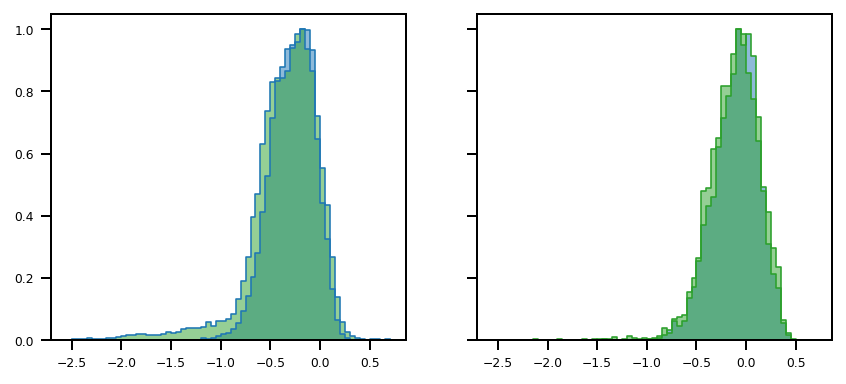

In [25]:

def both_type_bars(x, y, ax, yerr=None):
    ax.step(x, y, colours[col_num], lw=0.8)
    ax.bar(x-bin_width/2, y,
           yerr=yerr,
           width = bin_width, error_kw=dict(ecolor=kwargs['color']), **kwargs)
    
sns.set_context("paper", font_scale=0.7)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(3.5*2, 3.), sharey=True, sharex=True)

bin_width = 0.05
bins = np.arange(-2.5, 0.8, bin_width)
colours = ['C0', 'C2']

for col_num, sub_tables in enumerate([[galah_idr3[RC_jeffrey_idx & useful_giants_idx]['fe_h'],
                                       galah_idr3[RGB_jeffrey_idx & useful_giants_idx &
                                                  (galah_idr3['logg'] > 2.0)]['fe_h']], #!!!!!!!!!!!!!!!!!!
                                      [apogee_kepler[rc_apogee]['M_H'],
                                       apogee_kepler[rgb_apogee]['M_H']]]):
    for color_num, sub_table in enumerate(sub_tables):
        kwargs = dict(alpha=0.5, lw=1.0, color=colours[color_num])
        full_feh_counts, bin_edges = np.histogram(sub_table, bins=bins)    
        both_type_bars(bin_edges[:-1],
                       full_feh_counts/np.nanmax(full_feh_counts),
                       axes[col_num], yerr=None)

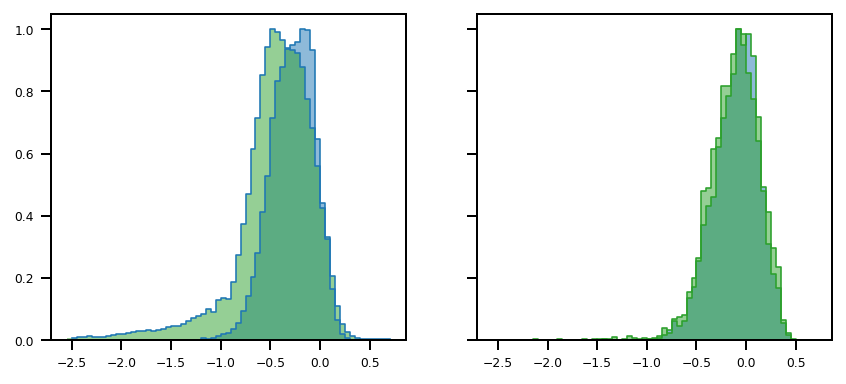

In [26]:

def both_type_bars(x, y, ax, yerr=None):
    ax.step(x, y, colours[col_num], lw=0.8)
    ax.bar(x-bin_width/2, y,
           yerr=yerr,
           width = bin_width, error_kw=dict(ecolor=kwargs['color']), **kwargs)
    
sns.set_context("paper", font_scale=0.7)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(3.5*2, 3.), sharey=True, sharex=True)

bin_width = 0.05
bins = np.arange(-2.5, 0.8, bin_width)
colours = ['C0', 'C2']

for col_num, sub_tables in enumerate([[galah_idr3[RC_jeffrey_idx & useful_giants_idx]['fe_h'],
                                       galah_idr3[RGB_jeffrey_idx & useful_giants_idx]['fe_h']], #!!!!!!!!!!!!!!!!!!
                                      [apogee_kepler[rc_apogee]['M_H'],
                                       apogee_kepler[rgb_apogee]['M_H']]]):
    for color_num, sub_table in enumerate(sub_tables):
        kwargs = dict(alpha=0.5, lw=1.0, color=colours[color_num])
        full_feh_counts, bin_edges = np.histogram(sub_table, bins=bins)    
        both_type_bars(bin_edges[:-1],
                       full_feh_counts/np.nanmax(full_feh_counts),
                       axes[col_num], yerr=None)

## All the abundances

0 0
0 1
0 2
0 3
0 4
2 0
2 1
2 2
2 3
2 4
4 0
4 1
4 2
4 3
4 4
6 0
6 1
6 2
6 3
6 4
8 0
8 1
8 2
8 3
8 4
10 0
10 1
10 2
10 3
10 4


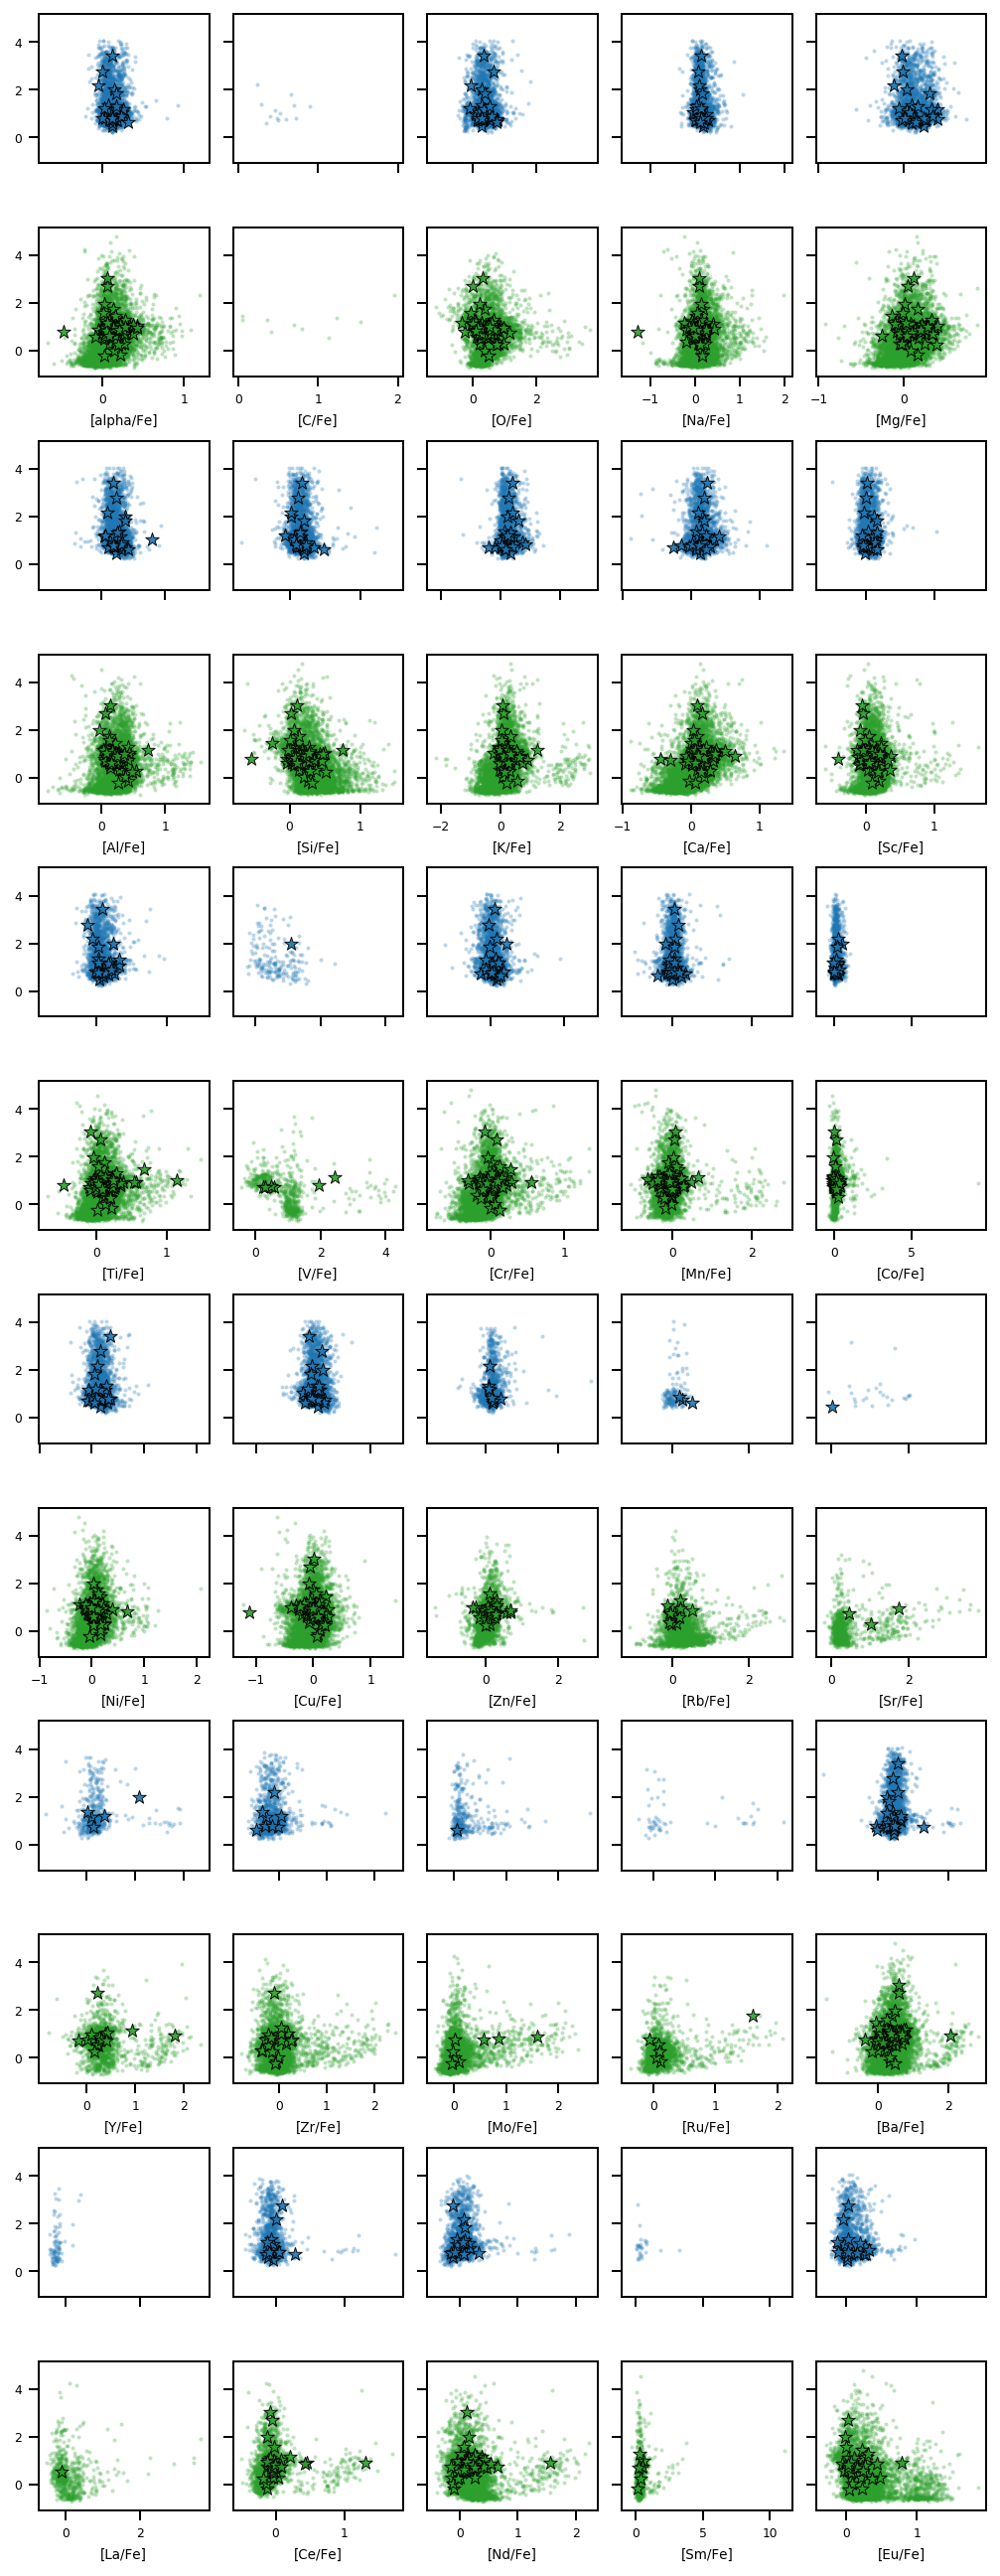

In [27]:
sns.set_context("paper", font_scale=0.7)

colors = ['C0', 'C2']
elem_list = [col.name for col in galah_idr3.columns if ((col.name not in ['Li_fe']) &
                                                        (col.name.endswith("_fe")) &
                                                        ~(col.name.startswith(("e_", "nr_"))))]
fig, axes = plt.subplots(nrows=6*2, ncols=5, figsize=(3.5*2, 9.0*2), sharey=True)
row_counter = 0
col_counter = 0
for elem_count, elem in enumerate(elem_list):
    print(row_counter, col_counter)
    ax_elem = axes[row_counter:row_counter+2,col_counter]
    for row_count, plot_list in enumerate(plot_lists):
        for idx_count, idx_select in enumerate(plot_list[0]):
            ax_elem[idx_count].scatter(galah_idr3[elem][idx_select & useful_li_giants_idx],
                                       galah_idr3['a_li'][idx_select & useful_li_giants_idx],
                                       c = colors[idx_count],
                                       **plot_list[1])
    [ax.set_xlim(min([ax.get_xlim()[0] for ax in ax_elem]),
                 max([ax.get_xlim()[1] for ax in ax_elem])) for ax in ax_elem]
    ax_elem[0].get_xaxis().set_ticklabels([])
    ax_elem[1].set_xlabel(f"[{elem.split('_')[0]}/Fe]")
    col_counter += 1
    if col_counter > np.shape(axes)[1]-1:
        col_counter = 0
        row_counter += 2
fig.tight_layout()